# **Project Introduction**
Verbal Communication is valuable and sought after in workplace and classroom environments alike. There is no denying the notion that Indians lack verbal communication and consequently lag behind in the workplace or classroom environments. This happens despite them having strong technical competencies. Clear and comprehensive speech is the vital backbone of strong communication and
presentation skills. Where some occupations consist mainly of presenting, most careers require and thrive from the ability to communicate effectively. Research has shown that verbal communication remains one of the most employable skills in both the perception of employers and new graduates. Of the possible improvements to vocal presentations tone, disfluencies, and stutters, in particular, remain one of the most common and prominent factors of someone’s demonstration. Millions of people are affected by stuttering and other speech disfluencies, with the majority of the world having experienced mild stutters while communicating under stressful conditions. Research shows that mild disfluencies can be cured without medical help, just practicing speech regularly and constructive feedbacks are effective ways to improve. 

We, Data Scientists recognize this problem and say hello.


# **Problem Statement**
We will solve the above-mentioned problem by applying deep learning algorithms to audio/speech
data. The solution will be to identify emotions in speech.

**DATA SOURCE USED**

We have used the RAVDESS dataset in this project.It is one of the more common dataset used for this excercise by others. It's well liked because of its quality of speakers, recording and it has 24 actors of different genders.
Here's the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Here's an example of an audio filename. 02-01-06-01-02-01-12.mp4

##**Importing Libraries**

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import Audio
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

#hide warnigs
import warnings  
warnings.filterwarnings(action='ignore')

In [2]:
# path to the dataset used in this project
RAV = "/content/drive/MyDrive/Colab Notebooks/Project/Speech/speech-emotion-recognition-ravdess-data/"

In [3]:
# Loading speech dataset and count according to the emotions-wise

dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

male_fear          96
male_disgust       96
male_surprise      96
male_calm          96
female_calm        96
female_surprise    96
female_disgust     96
male_sad           96
female_happy       96
male_happy         96
female_sad         96
male_angry         96
female_angry       96
female_fear        96
male_neutral       48
female_neutral     48
Name: labels, dtype: int64

# EXPLORATORY DATA ANALYSIS
The key features of the audio data are namely, MFCC (Mel Frequency Cepstral Coefficients), Mel Spectrogram and Chroma.

MFCC (Mel Frequency Cepstral Coefficients)- MFCC is taken on a Mel scale which is a scale that relates the perceived frequency of a tone to the actual measured frequency. It scales the frequency in order to match more closely what the human ear can hear. The envelope of the temporal power spectrum of the speech signal is representative of the vocal tract and MFCC accurately represents this envelope.
Mel Spectrogram- A Fast Fourier Transform is computed on overlapping windowed segments of the signal, and we get what is called the spectrogram. This is just a spectrogram that depicts amplitude which is mapped on a Mel scale.

Chroma- A Chroma vector is typically a 12-element feature vector indicating how much energy of each pitch class is present in the signal in a standard chromatic scale.

For the EDA we have used Mel Spectogram and MFCC

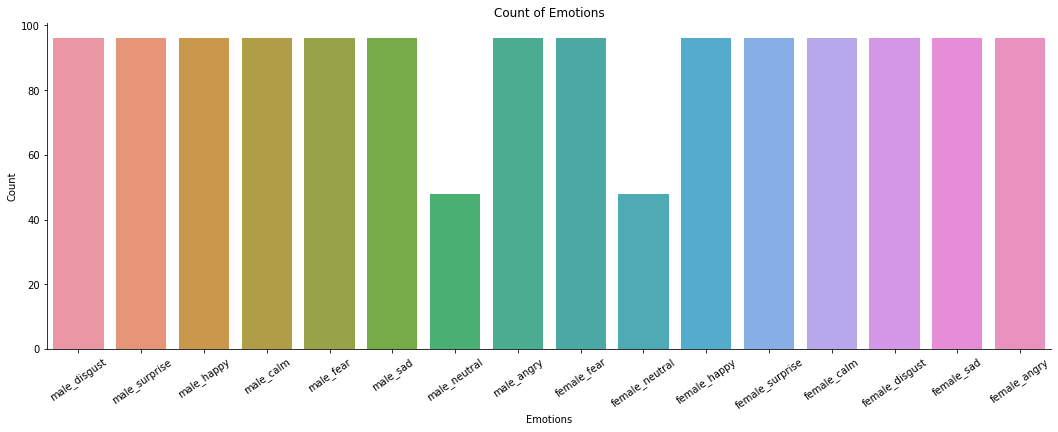

In [4]:
# visualize count of emotions-wise
plt.figure(figsize=(18,6))
plt.title('Count of Emotions', size=12)
sns.countplot(RAV_df.labels)
plt.ylabel('Count')
plt.xlabel('Emotions')
plt.xticks(rotation=35)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

**Comparing mel spectograms of male and female neutral, happy and fear audio clips.**

### Female Neutral audio clip

In [5]:
# Female Neutral audio clip
audio_clip = RAV + 'Actor_14/03-01-01-01-01-01-14.wav'
data, sr = librosa.load(audio_clip)
ipd.Audio(audio_clip) 

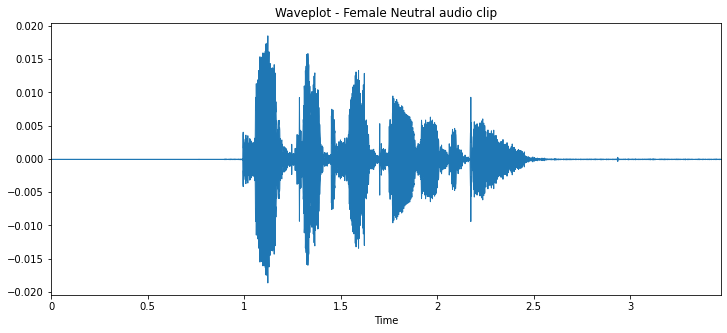

In [6]:
#waveplot
plt.figure(figsize=(12, 5))
librosa.display.waveplot(data, sr=sr)
plt.title('Waveplot - Female Neutral audio clip')
plt.show()

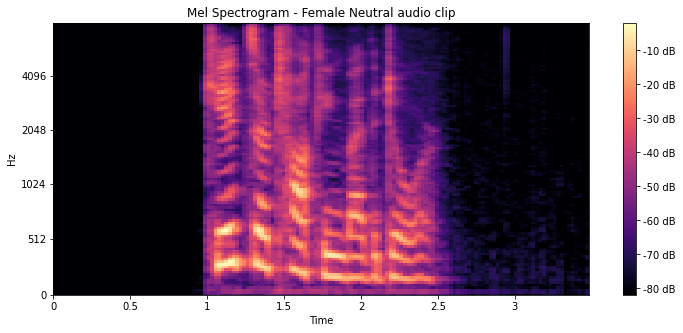

In [7]:
# Plot log mel spectrogram
plt.figure(figsize=(12, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram - Female Neutral audio clip')
plt.colorbar(format='%+2.0f dB')
plt.show()

### Male Neutral audio clip

In [8]:
# Male Neutral audio clip
audio_clip = RAV + 'Actor_01/03-01-01-01-01-01-01.wav'
data, sr = librosa.load(audio_clip)
ipd.Audio(audio_clip) 

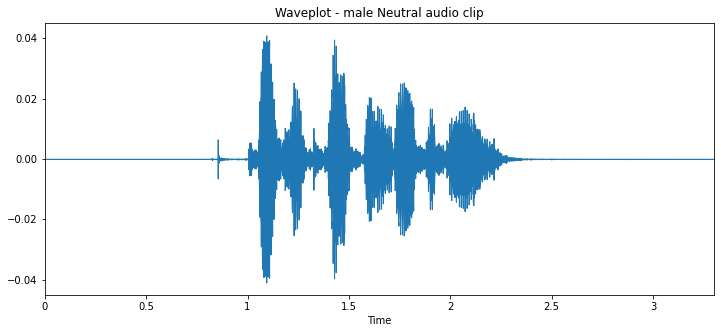

In [9]:
#waveplot
plt.figure(figsize=(12, 5))
librosa.display.waveplot(data, sr=sr)
plt.title('Waveplot - male Neutral audio clip')
plt.show()

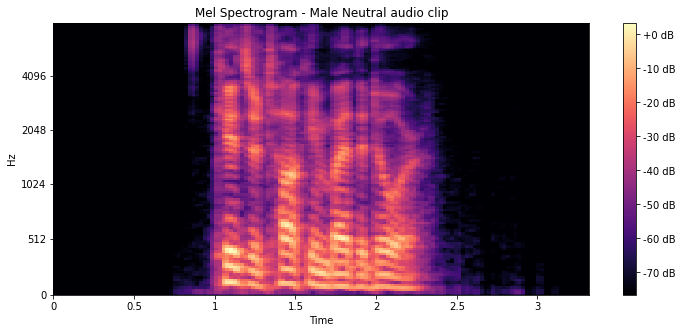

In [10]:
# Plot log mel spectrogram
plt.figure(figsize=(12, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram - Male Neutral audio clip')
plt.colorbar(format='%+2.0f dB')
plt.show()

### Female happy audio clip

In [11]:
# Female happy audio clip
audio_clip = RAV + 'Actor_14/03-01-03-02-02-02-14.wav'
data, sr = librosa.load(audio_clip)
ipd.Audio(audio_clip) 

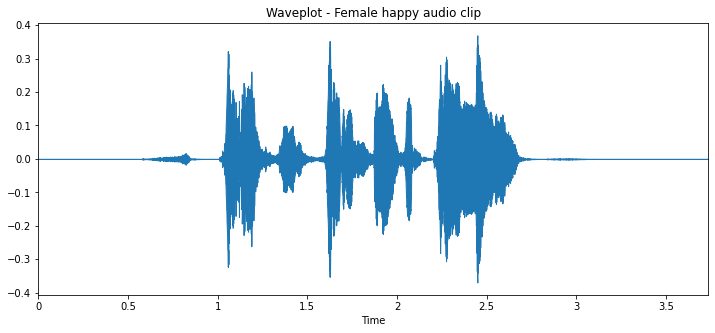

In [12]:
# waveplot
plt.figure(figsize=(12, 5))
librosa.display.waveplot(data, sr=sr)
plt.title('Waveplot - Female happy audio clip')
plt.show()

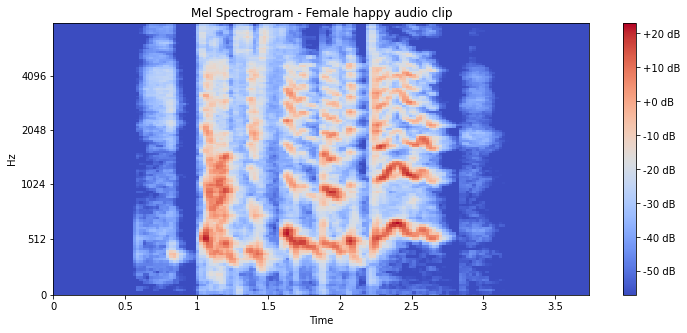

In [13]:
# Plot log mel spectrogram
plt.figure(figsize=(12, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram - Female happy audio clip')
plt.colorbar(format='%+2.0f dB')
plt.show()

### Female fear audio clip

In [14]:
# Female fear audio clip
audio_clip = RAV + 'Actor_14/03-01-06-02-02-02-14.wav'
data, sr = librosa.load(audio_clip)
ipd.Audio(audio_clip) 

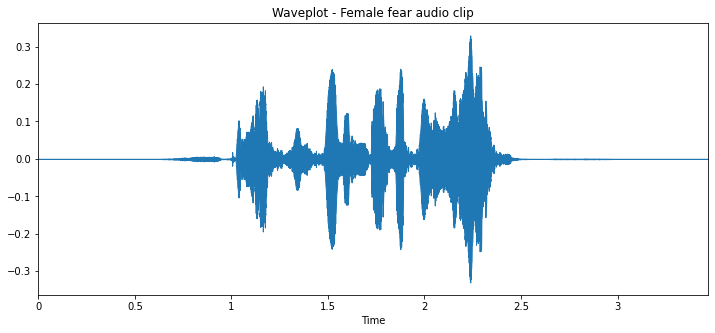

In [15]:
# waveplot
plt.figure(figsize=(12, 5))
librosa.display.waveplot(data, sr=sr)
plt.title('Waveplot - Female fear audio clip')
plt.show()

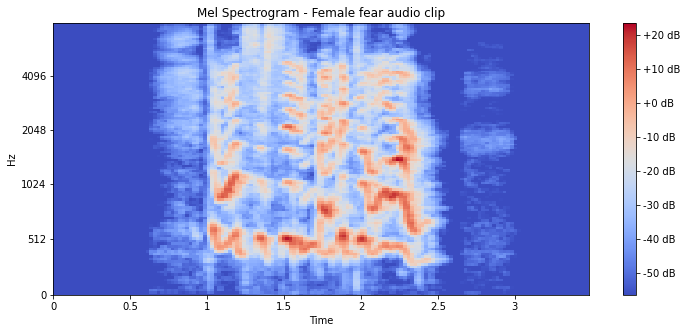

In [16]:
# Plot log mel spectrogram
plt.figure(figsize=(12, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram - Female fear audio clip')
plt.colorbar(format='%+2.0f dB')
plt.show()

**For the happy track it actually felt like it was a fear tone at the start, up until the end. We had to play it 4-5 times to finally be convienced that it is indeed a happy sound. Looking at the wave plot between the 2 audio clip, we noticed the only difference is the amplitute wherein this happy track has a higher amplituted at various points.**

**Comparing the MFCC feature for male and female angry audio clips**

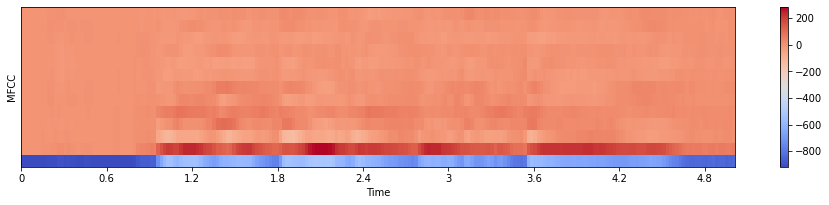

In [17]:
# Male angry audio clip
audio_clip = RAV+"Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(audio_clip, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# plot MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()
#play audio clip
ipd.Audio(audio_clip)

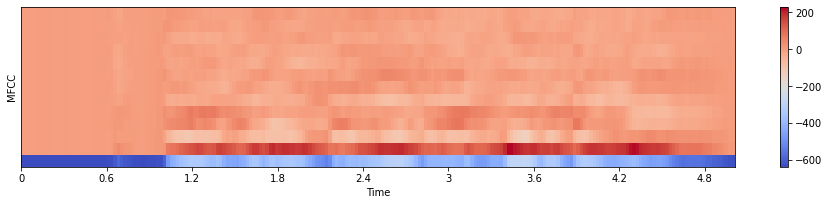

In [18]:
# Female angry audio clip
audio_clip = RAV+"Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(audio_clip, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# plot MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()
#play audio clip
ipd.Audio(audio_clip)

216
216


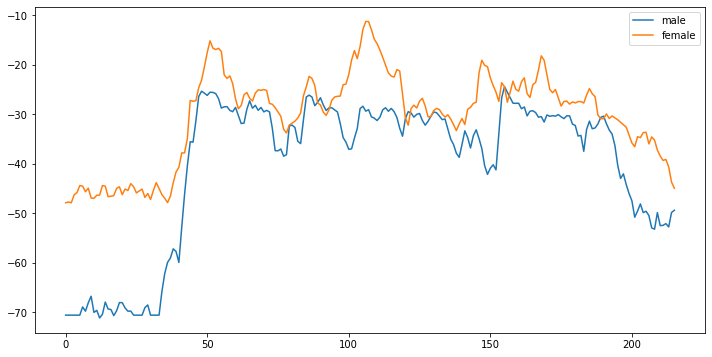

In [19]:
# Male angry audio clip
audio_clip = RAV+"Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(audio_clip, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# Female angry audio clip
audio_clip = RAV+"Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(audio_clip, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Ploting Male and Female angry audio waves together
plt.figure(figsize=(12,6))
plt.plot(male, label='male')
plt.plot(female, label='female')
plt.legend()
plt.show()

**For the same sentence being uttered, there is a clear distint difference between male and female in that females tends to have a higher pitch.**

# DATA AUGMENTATION

* Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
* To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
* The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
In order to this to work adding the perturbations must conserve the same label as the original training sample.

In [20]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [21]:
# Trying different functions above
path = np.array(RAV_df['path'])[303]
data, sample_rate = librosa.load(path)

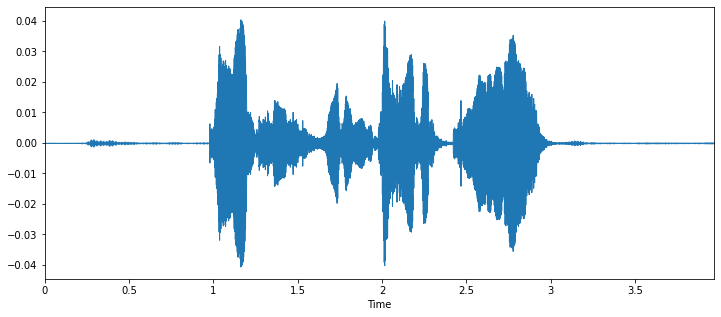

In [22]:
# NORMAL AUDIO
plt.figure(figsize=(12, 5))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

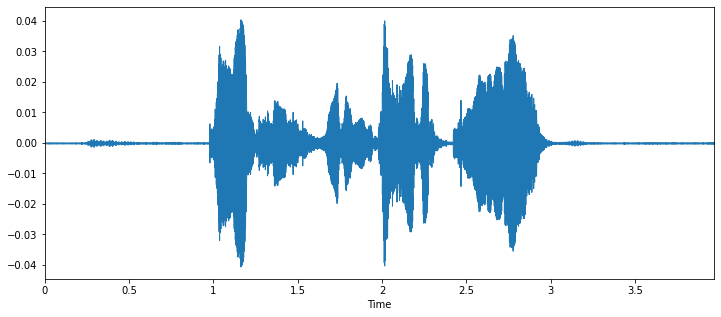

In [23]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

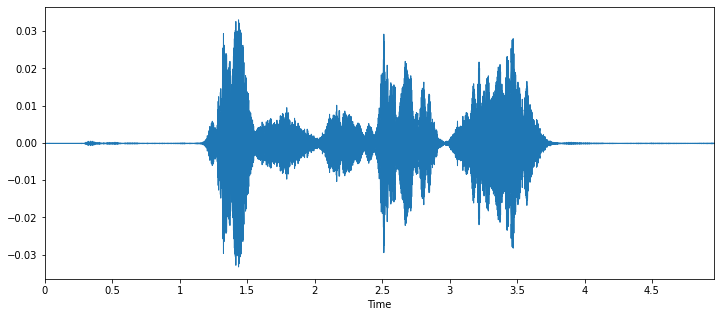

In [24]:
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

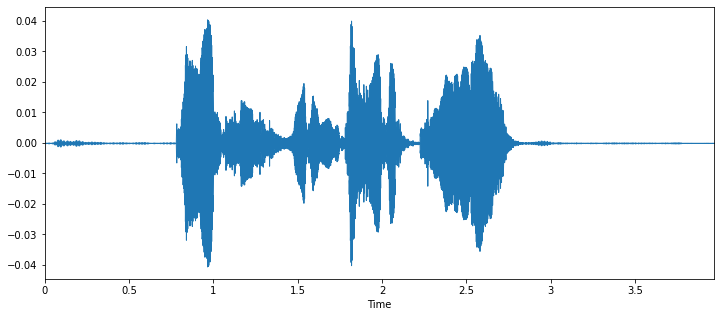

In [25]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

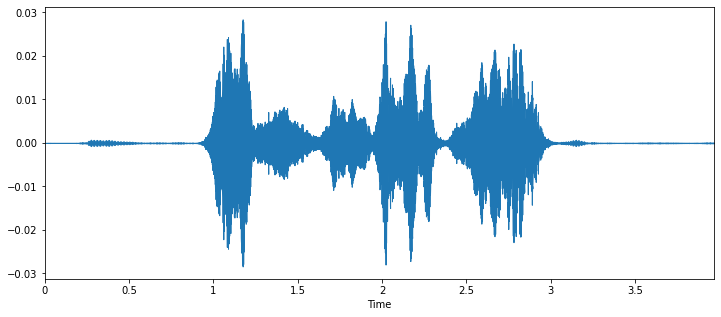

In [26]:
# AUDIO WITH PITCH
x = pitch(data, sample_rate)
plt.figure(figsize=(12, 5))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

**After listening to all augmented audio, it's decided to use noise, stretch and pitch for augmenting data.**

# FEATURE EXTRACTION

In [27]:
# function for feature extraction
def feat_ext(data):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc

def get_feat(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # normal data
    res1 = feat_ext(data)
    result = np.array(res1)
    #data with noise
    noise_data = noise(data)
    res2 = feat_ext(noise_data)
    result = np.vstack((result, res2))
    #data with stretch and pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = feat_ext(data_stretch_pitch)
    result = np.vstack((result, res3))
    return result

In [28]:
# fdataset first 5 datapoint
RAV_df.head()

,labels,source,path
0,male_disgust,RAVDESS,/content/drive/MyDrive/Colab Notebooks/Project...
1,male_surprise,RAVDESS,/content/drive/MyDrive/Colab Notebooks/Project...
2,male_surprise,RAVDESS,/content/drive/MyDrive/Colab Notebooks/Project...
3,male_happy,RAVDESS,/content/drive/MyDrive/Colab Notebooks/Project...
4,male_disgust,RAVDESS,/content/drive/MyDrive/Colab Notebooks/Project...


In [29]:
# seprate data and emotions
X, Y = [], []
for path, emotion in zip(RAV_df['path'], RAV_df['labels']):
    feature = get_feat(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [31]:
# export datset as csv format
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,labels
0,-579.285156,104.878593,-23.797998,32.649773,-10.372886,11.423226,-20.556746,-3.292210,-24.404179,-5.226639,-0.239077,-14.412207,1.152623,-14.766744,2.274485,-8.267848,-7.143617,-7.189220,-4.785932,-5.356423,male_disgust
1,-507.417845,58.812614,1.560783,13.686489,0.492792,2.498898,-10.484716,-9.490825,-16.068393,-5.696794,-0.846862,-8.294669,-3.931958,-8.128242,-1.920643,-4.968030,-7.897783,-6.598525,-4.751206,-6.258032,male_disgust
2,-631.961670,93.613235,-21.161810,30.659437,-9.771869,8.032961,-24.734560,-6.116055,-25.856428,-1.345405,-6.789199,-13.809713,-3.995386,-14.566345,1.174748,-12.223785,-6.739387,-9.365887,-4.130996,-9.932187,male_disgust
3,-495.307800,81.434631,-27.574680,28.701103,-15.656692,8.211281,-19.094063,-4.362455,-19.874475,-8.659778,-0.289792,-12.859628,1.619000,-9.765270,-4.522029,-5.674718,-7.773764,-10.187931,-2.036541,-7.168964,male_surprise
4,-281.667504,24.398891,4.107494,4.365077,-0.198114,-3.165992,-4.535816,-7.059885,-9.433339,-5.773020,-3.246435,-4.110436,-2.752163,-4.436683,-4.472789,-2.313979,-4.956533,-4.754328,-2.365148,-3.582729,male_surprise


In [32]:
# can use this directly from saved feature .csv file
Features = pd.read_csv('./features.csv')
Features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,labels
0,-579.285156,104.878593,-23.797998,32.649773,-10.372886,11.423226,-20.556746,-3.292210,-24.404179,-5.226639,-0.239077,-14.412207,1.152623,-14.766744,2.274485,-8.267848,-7.143617,-7.189220,-4.785932,-5.356423,male_disgust
1,-507.417845,58.812614,1.560783,13.686489,0.492792,2.498898,-10.484716,-9.490825,-16.068393,-5.696794,-0.846862,-8.294669,-3.931958,-8.128242,-1.920643,-4.968030,-7.897783,-6.598525,-4.751206,-6.258032,male_disgust
2,-631.961670,93.613235,-21.161810,30.659437,-9.771869,8.032961,-24.734560,-6.116055,-25.856428,-1.345405,-6.789199,-13.809713,-3.995386,-14.566345,1.174748,-12.223785,-6.739387,-9.365887,-4.130996,-9.932187,male_disgust
3,-495.307800,81.434631,-27.574680,28.701103,-15.656692,8.211281,-19.094063,-4.362455,-19.874475,-8.659778,-0.289792,-12.859628,1.619000,-9.765270,-4.522029,-5.674718,-7.773764,-10.187931,-2.036541,-7.168964,male_surprise
4,-281.667504,24.398891,4.107494,4.365077,-0.198114,-3.165992,-4.535816,-7.059885,-9.433339,-5.773020,-3.246435,-4.110436,-2.752163,-4.436683,-4.472789,-2.313979,-4.956533,-4.754328,-2.365148,-3.582729,male_surprise


# DATA PREPROCESSING

In [33]:
# assign value to X and Y
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [34]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [35]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 20), (3240, 16), (1080, 20), (1080, 16))

In [36]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 20), (3240, 16), (1080, 20), (1080, 16))

# IMPLOYING MODELS

## **KNN Model**

In [37]:
from sklearn.neighbors import KNeighborsClassifier
clf1=KNeighborsClassifier(n_neighbors=3)
clf1.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [38]:

y_pred=clf1.predict(x_test)

In [39]:
print("Training set score: {:.3f}".format(clf1.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf1.score(x_test, y_test)))

Training set score: 0.794
Test set score: 0.552


## **MLP CLASSIFIER**

In [40]:
from sklearn.neural_network import MLPClassifier
clf2=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=400)
clf2.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=400)

In [41]:
y_pred=clf2.predict(x_test)

In [42]:
print("Training set score: {:.3f}".format(clf2.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf2.score(x_test, y_test)))

Training set score: 0.875
Test set score: 0.563


## **CNN**

In [43]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((3240, 20, 1), (3240, 16), (1080, 20, 1), (1080, 16))

In [44]:
import tensorflow as tf 

model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))

model.add(LSTM(128))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 2048)          12288     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 2048)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 10, 2048)         8192      
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 1024)          10486784  
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 1024)          0         
 1D)                                                             
                                                        

In [45]:
history = model.fit(x_traincnn, y_train, batch_size=64, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
51/51 [==============================] - 19s 55ms/step - loss: 2.7518 - accuracy: 0.0821 - val_loss: 2.7682 - val_accuracy: 0.0574
Epoch 2/200
51/51 [==============================] - 2s 30ms/step - loss: 2.7193 - accuracy: 0.0914 - val_loss: 2.7626 - val_accuracy: 0.0861
Epoch 3/200
51/51 [==============================] - 2s 30ms/step - loss: 2.6719 - accuracy: 0.1130 - val_loss: 2.7507 - val_accuracy: 0.0750
Epoch 4/200
51/51 [==============================] - 2s 30ms/step - loss: 2.6306 - accuracy: 0.1256 - val_loss: 2.7396 - val_accuracy: 0.0722
Epoch 5/200
51/51 [==============================] - 2s 30ms/step - loss: 2.5878 - accuracy: 0.1410 - val_loss: 2.7223 - val_accuracy: 0.0741
Epoch 6/200
51/51 [==============================] - 2s 31ms/step - loss: 2.5384 - accuracy: 0.1590 - val_loss: 2.7023 - val_accuracy: 0.0935
Epoch 7/200
51/51 [==============================] - 2s 30ms/step - loss: 2.4690 - accuracy: 0.1923 - val_loss: 2.6695 - val_accuracy: 0.1361
Epoch

In [47]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

34/34 [==============================] - 0s 12ms/step - loss: 1.7683 - accuracy: 0.7731
Accuracy of our model on test data :  77.31481194496155 %


**Since we got the best accuracy with the cnn model we will further be using it.**

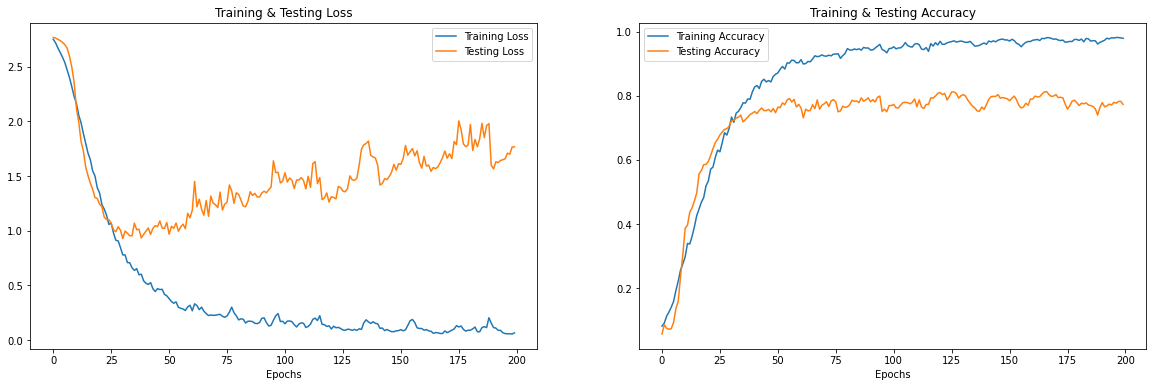

In [48]:
epochs = [i for i in range(200)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [49]:
pred_test = model.predict(x_testcnn)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,female_surprise,female_surprise
1,male_happy,male_happy
2,female_calm,female_calm
3,female_surprise,female_surprise
4,female_surprise,female_surprise
5,female_happy,female_happy
6,male_fear,male_disgust
7,male_angry,male_angry
8,female_calm,female_calm
9,male_fear,male_fear


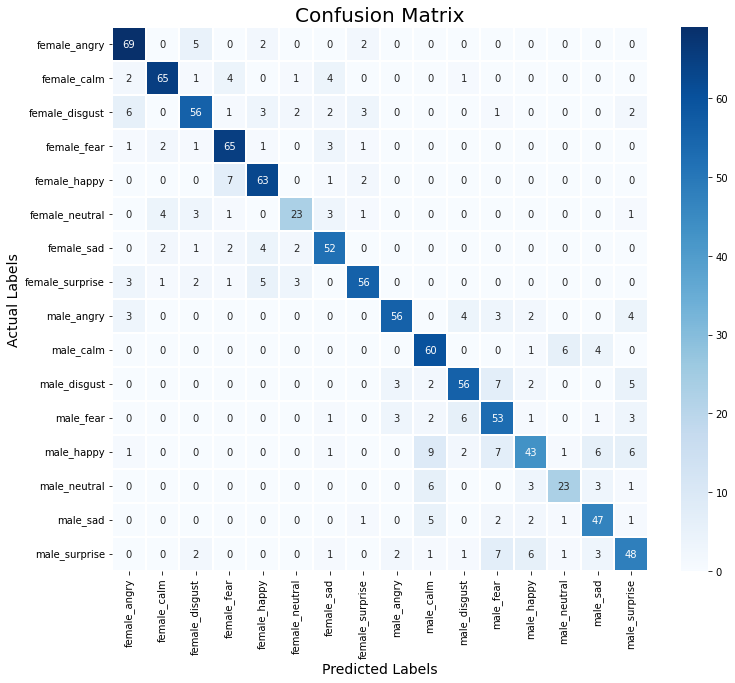

In [50]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

## **SAVING THE MODEL**

In [58]:
model_name = 'speech_emotions_recognition.h5'
save_dir = os.path.join("/content/drive/MyDrive/Colab Notebooks/Project/Speech_Emotion_Recognition/", 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/MyDrive/Colab Notebooks/Project/Speech_Emotion_Recognition/saved_models/speech_emotions_recognition.h5 


In [59]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [60]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Colab Notebooks/Project/Speech_Emotion_Recognition/saved_models/speech_emotions_recognition.h5")
print("Loaded model from disk")

Loaded model from disk
